# Import Library

In [39]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

## Load Data

In [40]:
item = pd.read_csv('item_to_id.csv')
purchase_history = pd.read_csv('purchase_history.csv')

In [41]:
print('There are {} customers and {} items in total.'.format(purchase_history['user_id'].nunique(), len(item)))

There are 24885 customers and 48 items in total.


In [42]:
purchase_history

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."
...,...,...
39469,704794,"48,42,44,10,2"
39470,31237,"23,21,26,27,41,9,47,43,20,40,16,24,46"
39471,724925,"3,39,28,4,1,43,47,27,18,25,44,10,30,2"
39472,651509,"13,39,20,32,37,1,3,18,34"


### Q1: The customer who bought the most items overall in her lifetime

In [43]:
user_count = purchase_history.groupby('user_id')['id'].apply(lambda x: len(','.join(x).split(','))).reset_index()
user_count = user_count.rename(columns = {'id':'count'})
[max_user_id, max_count] = user_count.iloc[user_count['count'].idxmax()]

In [44]:
print('The customer who bought the most items is {}, she bought {} items.'.format(max_user_id, max_count))

The customer who bought the most items is 269335, she bought 72 items.


### Q2: The customer who bought each product the most

In [45]:
user_item = purchase_history.groupby('user_id')['id'].apply(lambda x: list(map(int,','.join(x).split(',')))).reset_index()

In [46]:
columns = ['user_id'] + [str(i) for i in range(1,49)]
# create a crosswalk table of all customers and all items
purchase_df = pd.DataFrame(columns=columns)

In [47]:
for index_count in range(len(user_item)):
    items_list = user_item['id'][index_count]
    row = [user_item['user_id'][index_count]]
    for number in range(1,49):
        count = 0
        for i in items_list:
            if i == number:
                count += 1
        row.append(count)
    purchase_df = purchase_df.append(pd.Series(row,index=columns),ignore_index=True).astype(int)

In [48]:
purchase_df.head()

,user_id,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,47,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1,68,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,113,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,123,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,223,1,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [49]:
columns = [str(i) for i in range(1,49)]
most_item_user_df = []

for index in range(1,49):
    user = purchase_df.iloc[purchase_df[str(index)].idxmax()]['user_id']
    most_item_user_df.append(user)
    
q2_result = pd.DataFrame(list(zip(columns, most_item_user_df)), columns = [['item_id', 'user_id']])

In [50]:
q2_result

,item_id,user_id
0,1,31625
1,2,31625
2,3,154960
3,4,5289
4,5,217277
5,6,334664
6,7,175865
7,8,151926
8,9,269335
9,10,618914


## Q2: Considering ranking ties 

In [51]:
user_purchase_item = purchase_history.groupby('user_id')['id'].apply(lambda x: ','.join(x).split(',')).reset_index()

df = user_purchase_item.explode('id')
df['count'] = 1

df = df.groupby(['id', 'user_id']).count().reset_index()

idx = df.groupby('id')['count'].transform(max) == df['count']
q2_result_w_ties = df[idx].astype(int).sort_values(by = 'id')

In [52]:
q2_result_w_ties

,id,user_id,count
171,1,31625,4
369,1,68836,4
2913,1,540483,4
5920,1,1091637,4
7021,1,1301034,4
...,...,...,...
262994,48,1329628,3
259540,48,342220,3
259509,48,335841,3
260896,48,728584,3


# Q3: create clusters of products

### K-means algorithm

In [53]:
item_name = item.sort_values(by = 'Item_id')['Item_name'].astype(str)
purchase_name_df = purchase_df.drop(columns = 'user_id', axis = 1)
purchase_name_df.columns = item_name

In [54]:
purchase_name_df

Item_name,sugar,lettuce,pet items,baby items,waffles,poultry,sandwich bags,butter,soda,carrots,...,sandwich loaves,berries,ketchup,cucumbers,coffee,broccoli,cauliflower,bananas,pork,yogurt
0,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24880,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
24881,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
24882,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,1,1,0,0,1
24883,1,2,0,0,0,1,0,1,1,2,...,0,0,0,2,1,2,1,0,1,1


In [55]:
scaler = StandardScaler()
X = scaler.fit_transform(purchase_name_df.T)

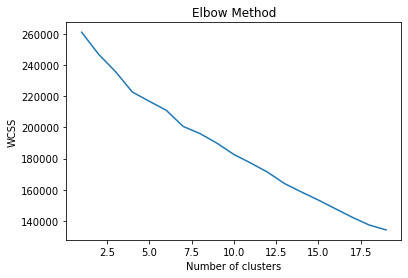

In [56]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=300, n_init=10, random_state=19)
    kmeans.fit(purchase_name_df.T)
    wcss.append(kmeans.inertia_) # sum of squared distance between data and centroid
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

There is no clear elbow point. So I choose k = 12 based on the type of items.

In [58]:
kmeans = KMeans(n_clusters = 12, init='random', max_iter=300, n_init=10, random_state = 19)
kmeans.fit(purchase_name_df.T)

labels = map(int, list(kmeans.labels_))

In [82]:
purchase_name_df

Item_name,sugar,lettuce,pet items,baby items,waffles,poultry,sandwich bags,butter,soda,carrots,...,sandwich loaves,berries,ketchup,cucumbers,coffee,broccoli,cauliflower,bananas,pork,yogurt
0,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24880,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
24881,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
24882,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,1,1,0,0,1
24883,1,2,0,0,0,1,0,1,1,2,...,0,0,0,2,1,2,1,0,1,1


In [79]:
centers = kmeans.cluster_centers_

In [80]:
labels = kmeans.labels_

In [ ]:
for c_idx in range(len(centers)):
    for l in labels:
        if c_idx = l:
            new_weight.append(centers[c_idx]) 

In [30]:
q3_result = pd.DataFrame(list(zip(purchase_name_df.columns, labels)), columns = ['item_name', 'cluster'])
q3_result.sort_values(['cluster', 'item_name'], ascending=[True, False])

,item_name,cluster
33,tortillas,0
36,dinner rolls,0
12,bagels,0
1,lettuce,1
40,ketchup,2
22,tea,3
47,yogurt,4
4,waffles,4
32,toilet paper,4
0,sugar,4


## Another view: using correlation between items as input data

In [31]:
corr_df = purchase_name_df.corr()

In [32]:
corr_df

Item_name,sugar,lettuce,pet items,baby items,waffles,poultry,sandwich bags,butter,soda,carrots,...,sandwich loaves,berries,ketchup,cucumbers,coffee,broccoli,cauliflower,bananas,pork,yogurt
Item_name,,,,,,,,,,,,,,,,,,,,,
sugar,1.000000,0.238886,0.206039,0.136735,0.119243,0.135914,0.102346,0.121821,0.156018,0.137604,...,0.137811,0.136908,0.137097,0.136645,0.144441,0.145333,0.134491,0.141004,0.142335,0.111465
lettuce,0.238886,1.000000,0.219637,0.135994,0.103919,0.187290,0.118194,0.146822,0.179812,0.278273,...,0.182032,0.176002,0.153458,0.274880,0.179008,0.276240,0.264485,0.172360,0.176098,0.130249
pet items,0.206039,0.219637,1.000000,0.129327,0.078257,0.127229,0.079229,0.103597,0.130854,0.117942,...,0.119305,0.139074,0.098749,0.121215,0.115766,0.130672,0.128459,0.118695,0.119167,0.097790
baby items,0.136735,0.135994,0.129327,1.000000,0.056863,0.077653,0.050284,0.072546,0.083298,0.090476,...,0.076650,0.094112,0.056822,0.071046,0.083933,0.083373,0.078750,0.083247,0.094719,0.075080
waffles,0.119243,0.103919,0.078257,0.056863,1.000000,0.075596,0.057751,0.069173,0.081988,0.075511,...,0.079143,0.080804,0.070014,0.078525,0.076359,0.084528,0.078992,0.079078,0.074524,0.050996
poultry,0.135914,0.187290,0.127229,0.077653,0.075596,1.000000,0.100229,0.115662,0.136986,0.124579,...,0.128037,0.131981,0.115631,0.136225,0.132931,0.131153,0.141942,0.127709,0.294482,0.107329
sandwich bags,0.102346,0.118194,0.079229,0.050284,0.057751,0.100229,1.000000,0.074615,0.086099,0.078680,...,0.079575,0.084876,0.078163,0.094412,0.078656,0.082629,0.082967,0.079929,0.083486,0.062632
butter,0.121821,0.146822,0.103597,0.072546,0.069173,0.115662,0.074615,1.000000,0.104179,0.129987,...,0.109128,0.109570,0.087365,0.119632,0.096812,0.109044,0.113043,0.102149,0.108302,0.196273
soda,0.156018,0.179812,0.130854,0.083298,0.081988,0.136986,0.086099,0.104179,1.000000,0.129445,...,0.125823,0.136551,0.108813,0.123652,0.277274,0.124214,0.119791,0.135812,0.131368,0.093216


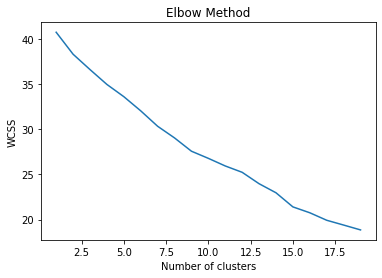

In [33]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=300, n_init=10, random_state=19)
    kmeans.fit(corr_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Still no clear elbow point, use the same k value as before.

In [34]:
kmeans = KMeans(n_clusters = 12, random_state = 19)
kmeans.fit(corr_df)

labels = map(int, list(kmeans.labels_))

In [35]:
q3_result = pd.DataFrame(list(zip(purchase_name_df.columns, labels)), columns = ['item_name', 'cluster'])
q3_result.sort_values(['cluster', 'item_name'], ascending=[True, False])

,item_name,cluster
47,yogurt,0
15,milk,0
13,eggs,0
20,cheeses,0
7,butter,0
33,tortillas,1
38,sandwich loaves,1
36,dinner rolls,1
12,bagels,1
19,grapefruit,2


The result now makes more intuitive sense than before.

## Hierarchical clustering

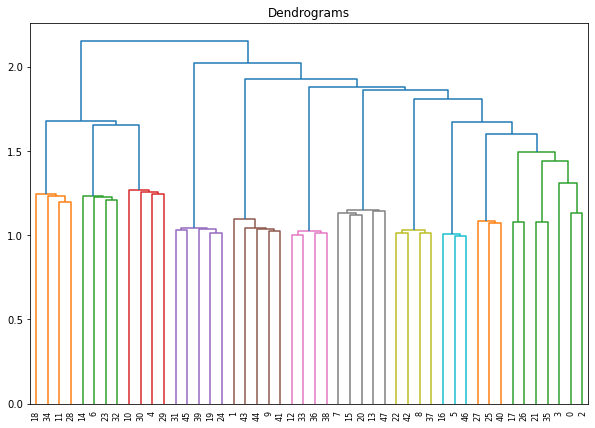

In [37]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(corr_df, method='ward'))

In [28]:
cluster = AgglomerativeClustering(n_clusters=13, affinity='euclidean', linkage='ward')  
labels = cluster.fit_predict(corr_df)

In [29]:
q3_result = pd.DataFrame(list(zip(purchase_name_df.columns, labels)), columns = ['item_name', 'cluster'])
q3_result.sort_values(['cluster', 'item_name'], ascending=[True, False])

,item_name,cluster
0,sugar,0
2,pet items,0
3,baby items,0
4,waffles,1
30,pasta,1
29,flour,1
10,cereals,1
47,yogurt,2
15,milk,2
13,eggs,2
